# Libraries

In [1]:
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
from os import listdir

from PIL import Image
from sklearn import metrics
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

# Load the Data

In [3]:
path = '/content/drive/MyDrive/DATASET/Images /archive - 2024-11-07T201235.258/data'
print('List dir:')
for file in os.listdir(path):
  print(file)

List dir:
validation
train


In [5]:
TRAIN_DIR = os.path.join(path, 'train')
VALIDATION_DIR = os.path.join(path, 'validation')

In [6]:
train_dir_alien = os.path.join(TRAIN_DIR, 'alien')
train_dir_predator = os.path.join(TRAIN_DIR, 'predator')
val_dir_alien = os.path.join(VALIDATION_DIR, 'alien')
val_dir_predator = os.path.join(VALIDATION_DIR, 'predator')

# Image Visualization

In [7]:
def display_images(image_dir, title, num_images=9):
  img_files = os.listdir(image_dir)[:num_images]
  fig, axes = plt.subplots(3, 3, figsize=(9, 9))
  axes = axes.flatten()

  for i, img_file in enumerate(img_files):
    image_path = os.path.join(image_dir, img_file)
    try:
      img = Image.open(image_path)
      axes[i].imshow(img)
      axes[i].axis('off')
    except Exception as e:
      print(f"Error opening {image_path}: {e}")

  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

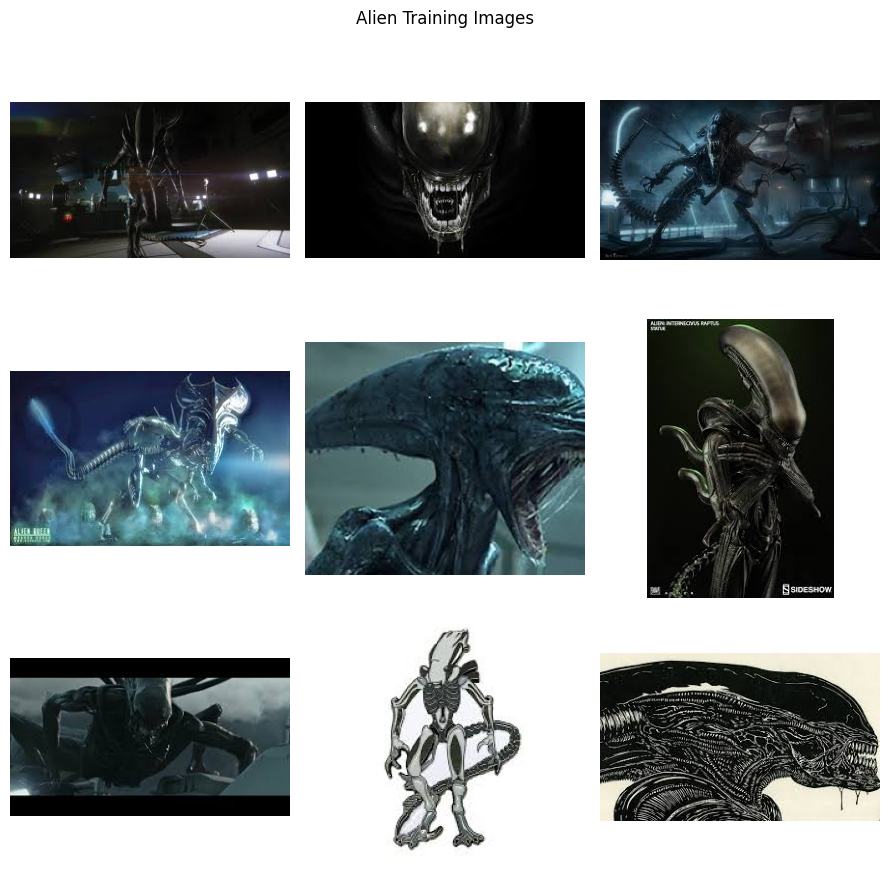

In [8]:
display_images(train_dir_alien, 'Alien Training Images')

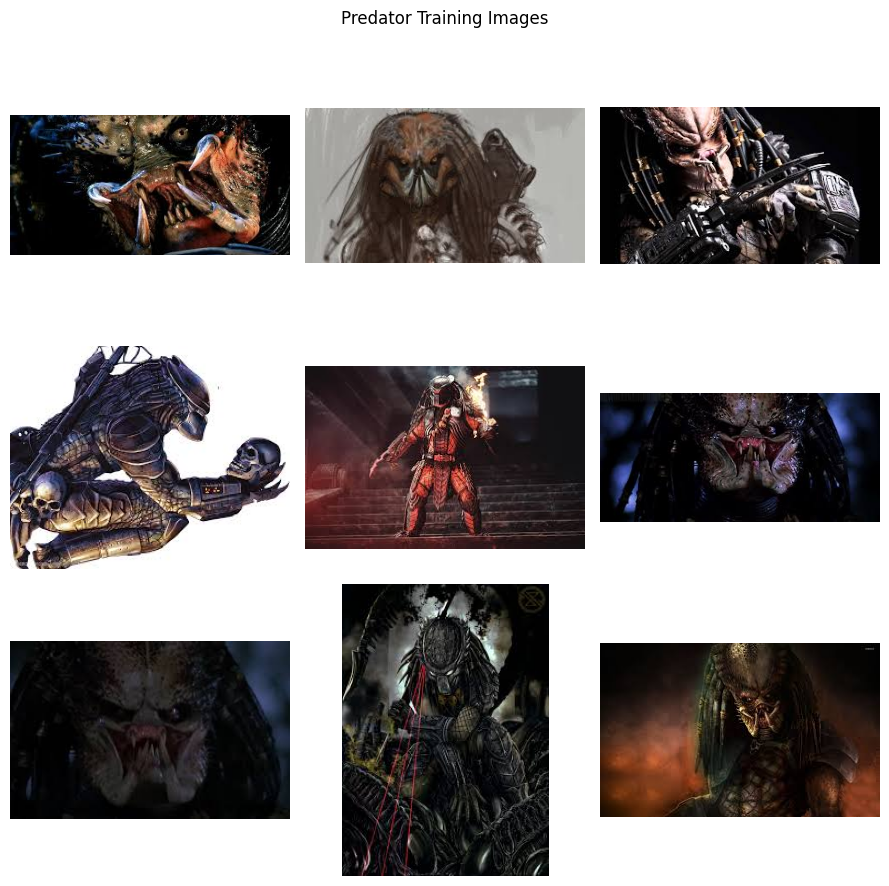

In [9]:
display_images(train_dir_predator, 'Predator Training Images')

# Data Augmentation

In [10]:
train_img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range=10,  # Menerapkan transformasi shear (kemiringan) pada gambar, menggeser piksel di sepanjang sumbu x atau y sehingga bentuk gambar sedikit berubah.
    rescale=1./255,  # Mereskalakan nilai piksel dengan membaginya 1/255, sehingga rentang piksel berubah dari [0, 255] menjadi [0, 1] untuk stabilitas pelatihan.
    horizontal_flip=True,  # Membalik gambar secara horizontal secara acak, berguna agar model lebih kuat terhadap orientasi kiri-kanan objek dalam gambar.
    zoom_range=0.2,  # Melakukan zoom acak hingga 20% pada gambar, membantu model belajar fitur dalam skala yang berbeda.
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input  # Menerapkan fungsi praproses khusus ResNet50, seperti normalisasi nilai piksel.
)

val_img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255
)

In [11]:
BATCH_SIZE = 32
IMG_SIZE = (120, 120)

train_data_gen = train_img_datagen.flow_from_directory(
    batch_size=BATCH_SIZE,            # Jumlah gambar per batch, sesuai BATCH_SIZE yang didefinisikan (32)
    directory=TRAIN_DIR,              # Path ke direktori berisi data latih (training data) dalam folder terstruktur per kelas.
    shuffle=True,                     # Mengacak urutan gambar untuk mencegah model belajar urutan tertentu pada gambar.
    target_size=IMG_SIZE,             # Ukuran gambar yang ditargetkan (120x120 piksel) agar konsisten saat dilatih.
    class_mode='binary'               # Mode klasifikasi biner, misalnya untuk dua kelas (seperti "kucing" dan "anjing").
)

val_data_gen = val_img_datagen.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=VALIDATION_DIR,
    shuffle=True,
    target_size=IMG_SIZE,
    class_mode='binary'
)

Found 704 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [12]:
pre_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
for layer in pre_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Modeling

In [18]:
pre_model.trainable = False

x = pre_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=pre_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │ 256)                   │                │                        │
├──────────────────────

 Total params: 26,215,297 (100.00 MB)

 Trainable params: 2,625,537 (10.02 MB)

 Non-trainable params: 23,589,760 (89.99 MB)

In [19]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
	train_data_gen,
	epochs=15,
  callbacks=[early_stop]
)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4988 - loss: 0.7685
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5098 - loss: 0.7118
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5766 - loss: 0.6940
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5836 - loss: 0.6789
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5842 - loss: 0.6714
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5683 - loss: 0.6826
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6479 - loss: 0.6452
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6371 - loss: 0.6355
Epoch 9/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6289 - loss: 0.6451
Epoch 10/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6594 - loss: 0.6110
Epoch 11/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6384 - loss: 0.6311
Epoch 12/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6794 - lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


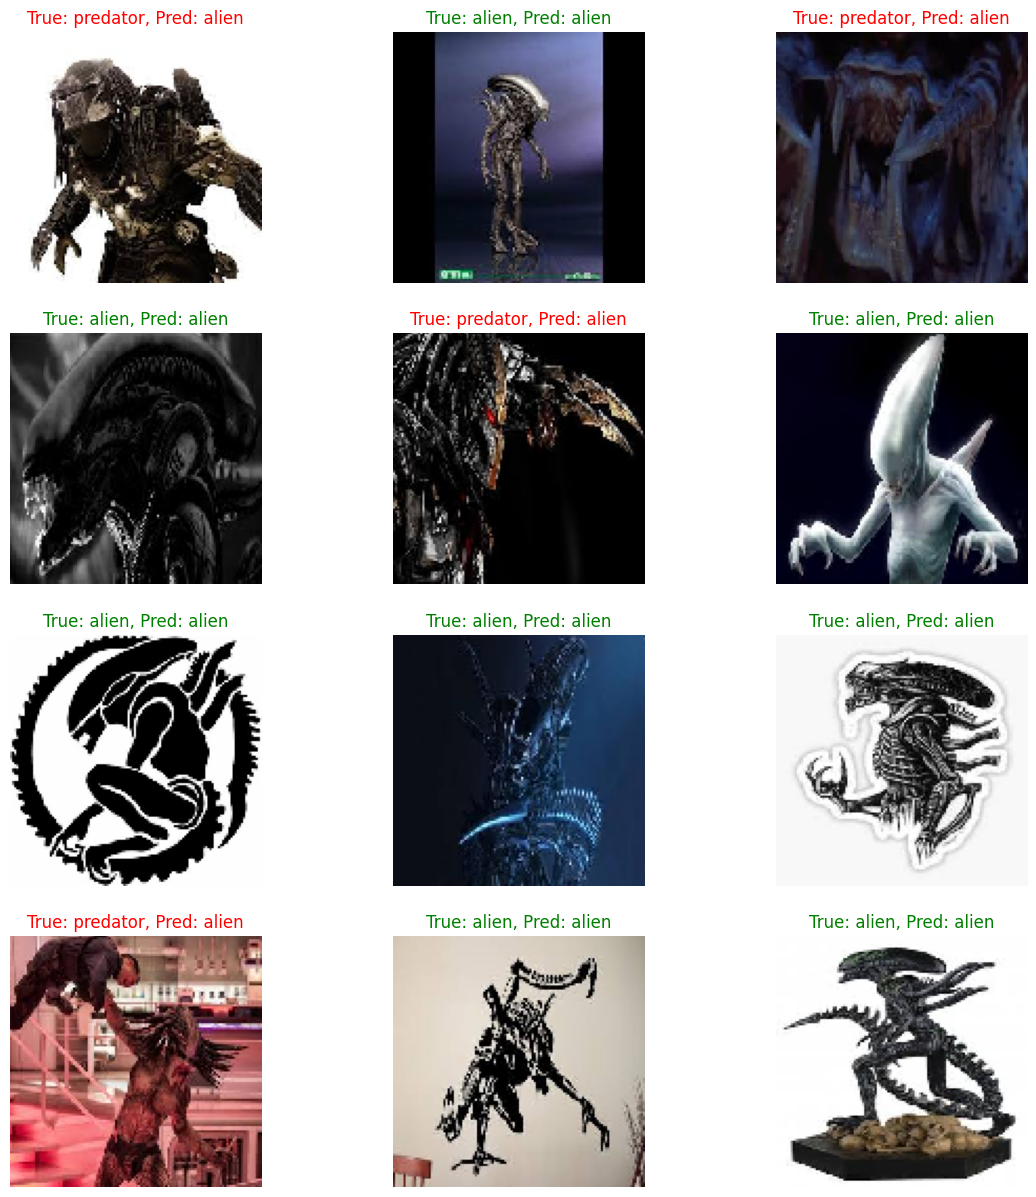

In [20]:
class_names = ['alien', 'predator']

def plot_prediction(dataset, model, n_images):
    images, labels = next(iter(dataset))

    predictions = np.argmax(model.predict(images), axis=1)

    labels = labels.astype('int32')
    if images.max() <= 1.0:
        images = images * 255.0

    images = np.clip(images, 0, 255).astype('uint8')

    plt.figure(figsize=(14, 15))
    i = 0
    for image, label, prediction in zip(images, labels, predictions):
        if i >= n_images:
            break
        plt.subplot(4, 3, i + 1)
        plt.imshow(image)
        title_obj = plt.title(f"True: {class_names[label]}, Pred: {class_names[prediction]}")
        if prediction == label:
            plt.setp(title_obj, color='g')
        else:
            plt.setp(title_obj, color='r')
        plt.axis('off')
        i += 1

    plt.show()

plot_prediction(val_data_gen, model, n_images=12)

In [21]:
eval_results = model.evaluate(val_data_gen)
print('Loss: {:.2f} - Accuracy: {:.2f}%'.format(eval_results[0], eval_results[1] * 100))

7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 7s/step - accuracy: 0.7512 - loss: 0.6351
Loss: 0.64 - Accuracy: 72.50%
